<a href="https://colab.research.google.com/github/jjungmini/solar/blob/main/231115_%ED%83%9C%EC%96%91%EA%B4%91_h2o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install prophet
!pip install h2o
!pip install mxnet
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.2-py2.py3-none-any.whl size=265363806 sha256=0707cb3fb4b9ddc4aed9258c2809faf28b3549524fab89cf8e35f6c1c0cb7f32
  Stored in directory: /root/.cache/pip/wheels/e9/ea/ab/889709967692e30c57c46137edd2cae6b2768bb65ec7cb8aa5
Successfully built h2o
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.7 MB/s eta 0:00:00


In [63]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns


In [64]:
# 데이터 로딩
df = pd.read_excel("경남 시간별 태양광 발전량_2020~230430_최종.xlsx")

In [65]:
df.columns

Index(['Date', 'YY', 'MM', 'DD', 'HH', 'solarpower', 'Temp_air',
       'Precipitation', 'Windspeed', 'Humidity', 'Pressure_air',
       'Pressure_sealevel', 'Sunshine', 'Insolation', 'Cloudcover',
       'Temp_ground', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'],
      dtype='object')

In [66]:
# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29184 entries, 0 to 29183
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               29184 non-null  datetime64[ns]
 1   YY                 29184 non-null  int64         
 2   MM                 29184 non-null  int64         
 3   DD                 29184 non-null  int64         
 4   HH                 29184 non-null  int64         
 5   solarpower         29184 non-null  float64       
 6   Temp_air           29184 non-null  float64       
 7   Precipitation      29184 non-null  float64       
 8   Windspeed          29184 non-null  float64       
 9   Humidity           29184 non-null  float64       
 10  Pressure_air       29184 non-null  float64       
 11  Pressure_sealevel  29184 non-null  float64       
 12  Sunshine           29184 non-null  float64       
 13  Insolation         29184 non-null  float64       
 14  Cloudc

In [67]:
df["Cloudcover"] = df["Cloudcover"][df["Cloudcover"].isnull()]=0

<ipython-input-67-04d58db406ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cloudcover"] = df["Cloudcover"][df["Cloudcover"].isnull()]=0


<Axes: xlabel='HH', ylabel='solarpower'>

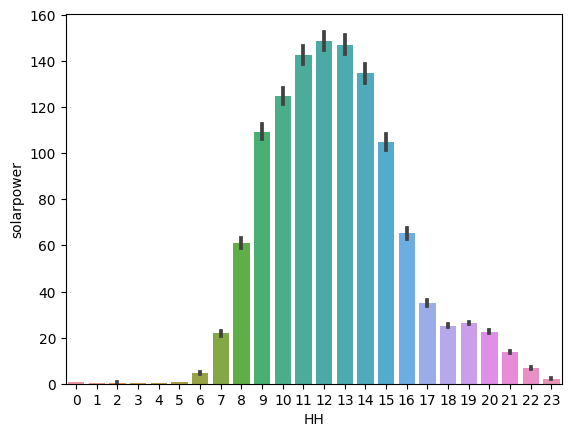

In [68]:
#시간별 태양광 발전량 그래프
sns.barplot(data=df, x='HH', y = 'solarpower')

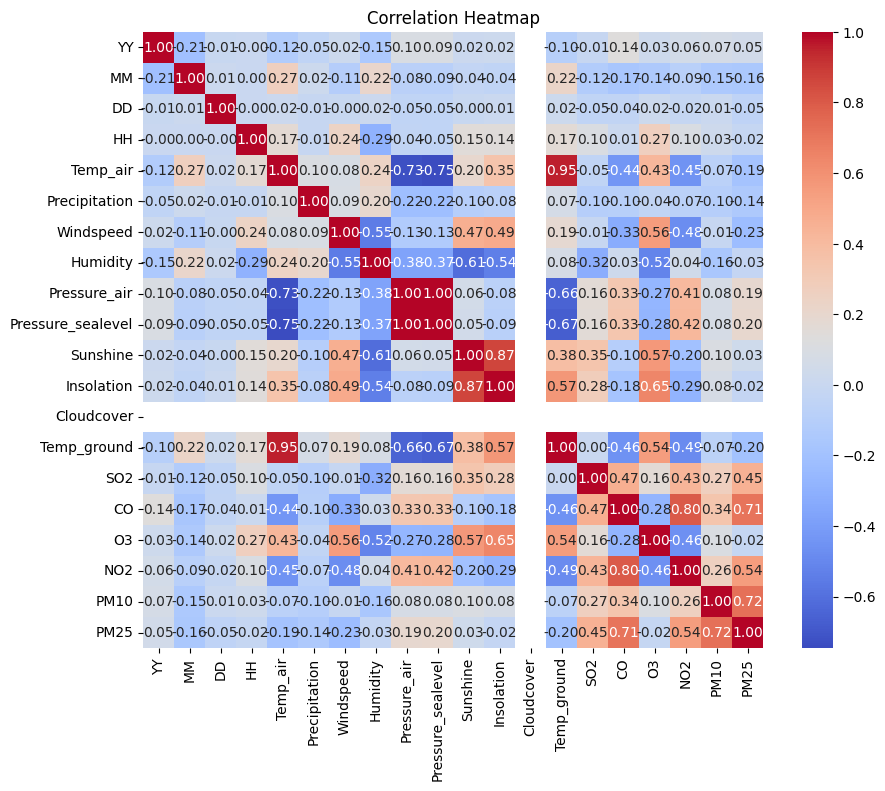

In [69]:
# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['solarpower'] = target_scaler.fit_transform(df[['solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외

correlation_matrix = df.drop(columns=['Date', 'solarpower']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [70]:
# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'solarpower'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2023-04-01']
test = df[(df['Date'] >= '2023-04-01') & (df['Date'] < '2023-05-01')]

In [39]:
train.tail()

,Date,YY,MM,DD,HH,solarpower,Temp_air,Precipitation,Windspeed,Humidity,...,Sunshine,Insolation,Cloudcover,Temp_ground,SO2,CO,O3,NO2,PM10,PM25
28459,2023-03-31 19:00:00,1.0,0.181818,1.0,0.826087,0.091232,0.634028,0.0,0.237369,0.254428,...,0.057143,0.016985,0.0,0.391369,0.243760,0.269159,0.577815,0.405076,0.064890,0.168500
28460,2023-03-31 20:00:00,1.0,0.181818,1.0,0.869565,0.095541,0.596741,0.0,0.148713,0.325282,...,0.000000,0.000000,0.0,0.358831,0.250842,0.289074,0.505929,0.430189,0.064314,0.179152
28461,2023-03-31 21:00:00,1.0,0.181818,1.0,0.913043,0.067090,0.561803,0.0,0.140133,0.405797,...,0.000000,0.000000,0.0,0.336454,0.218972,0.316145,0.435960,0.461580,0.066584,0.192608
28462,2023-03-31 22:00:00,1.0,0.181818,1.0,0.956522,0.039766,0.538168,0.0,0.132507,0.471014,...,0.000000,0.000000,0.0,0.315561,0.172938,0.322680,0.386598,0.446408,0.067032,0.200456
28463,2023-03-31 23:00:00,1.0,0.181818,1.0,1.000000,0.017173,0.512038,0.0,0.122021,0.524960,...,0.000000,0.000000,0.0,0.298436,0.169397,0.323302,0.359761,0.431758,0.067160,0.206997


In [40]:
test.tail()

,Date,YY,MM,DD,HH,solarpower,Temp_air,Precipitation,Windspeed,Humidity,...,Sunshine,Insolation,Cloudcover,Temp_ground,SO2,CO,O3,NO2,PM10,PM25
29179,2023-04-30 19:00:00,1.0,0.272727,0.966667,0.826087,0.068276,0.637992,0.0,0.307912,0.375201,...,0.464286,0.060863,0.0,0.409293,0.090919,0.158446,0.514096,0.132183,0.045165,0.093341
29180,2023-04-30 20:00:00,1.0,0.272727,0.966667,0.869565,0.072128,0.599530,0.0,0.242135,0.466184,...,0.000000,0.000708,0.0,0.377783,0.076372,0.175676,0.461923,0.166035,0.044016,0.093149
29181,2023-04-30 21:00:00,1.0,0.272727,0.966667,0.913043,0.061452,0.573106,0.0,0.173499,0.530596,...,0.000000,0.000000,0.0,0.357233,0.087283,0.190203,0.412704,0.202573,0.044607,0.099290
29182,2023-04-30 22:00:00,1.0,0.272727,0.966667,0.956522,0.040115,0.550646,0.0,0.129647,0.566828,...,0.000000,0.000000,0.0,0.341820,0.101830,0.204054,0.383172,0.224066,0.044325,0.100442
29183,2023-04-30 23:00:00,1.0,0.272727,0.966667,1.000000,0.017932,0.536994,0.0,0.111535,0.580515,...,0.000000,0.000000,0.0,0.328348,0.120014,0.210811,0.385387,0.206335,0.045625,0.104281


# feature selection

In [62]:
# 훈련 데이터를 이용하여 특성 선택을 위한 ElasticNetCV 모델을 생성합니다
enet_train = ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 1, 10],        # 후보 alpha 값 리스트
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],     # 후보 l1_ratio 값 리스트
    cv=5,                                   # 5-fold cross-validation 사용
    n_alphas=1000,                           # 100개의 alpha 값 생성
    max_iter=1000,                          # 최대 반복 횟수
    tol=1e-4,                               # 수렴 기준
    verbose=False,                          # 로그 출력 비활성화
    precompute='auto',                      # 자동으로 사전 계산된 Gram 행렬 결정
    selection='random',                      # 랜덤하게 특성 선택
    random_state=42
)
enet_train.fit(train.drop(columns=['Date', 'solarpower']), train['solarpower'])
# alpha 값을 출력합니다.
print('Best alpha: ', enet_train.alpha_)

# 선택된 특성만 남김
selected_features_train = train.drop(columns=['Date', 'solarpower']).columns[enet_train.coef_ != 0]
train = train[['Date', 'solarpower'] + selected_features_train.tolist()]

# 선택된 특성 출력
print("Selected features: ", selected_features_train.tolist())



Best alpha:  0.001
Selected features:  ['YY', 'MM', 'DD', 'HH', 'Temp_air', 'Windspeed', 'Humidity', 'Pressure_air', 'Pressure_sealevel', 'Sunshine', 'Insolation', 'Temp_ground', 'SO2', 'O3', 'NO2']


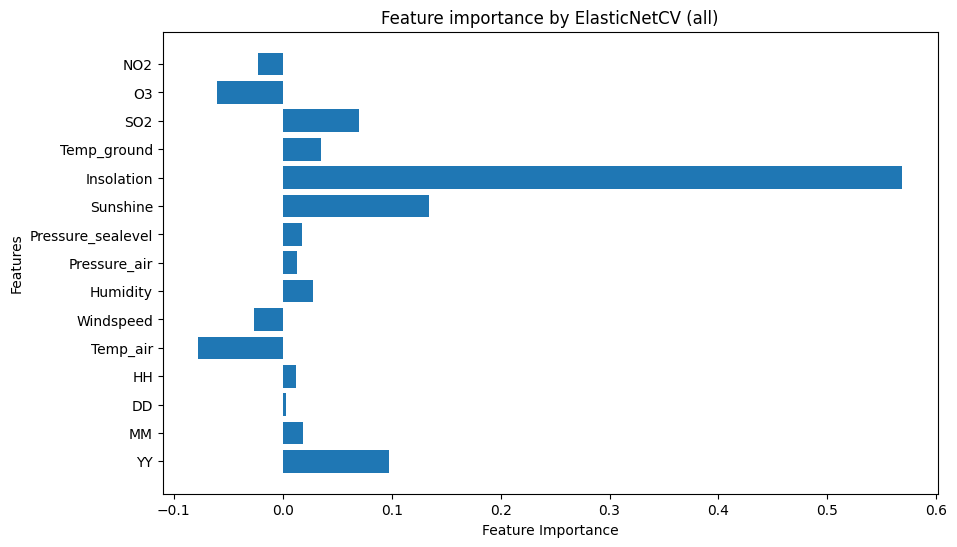

In [45]:
# ElasticNetCV의 결과를 출력합니다.
# 특성 중요도를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(range(len(enet_train.coef_)), enet_train.coef_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(len(enet_train.coef_)), enet_train.feature_names_in_)
plt.title('Feature importance by ElasticNetCV (all)')
plt.show()

In [71]:
 # 훈련 데이터를 이용하여 특성 선택을 위한 ElasticNetCV 모델을 생성합니다
enet_train = ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 1, 10],        # 후보 alpha 값 리스트
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],     # 후보 l1_ratio 값 리스트
    cv=5,                                   # 5-fold cross-validation 사용
    n_alphas=1000,                           # 100개의 alpha 값 생성
    max_iter=1000,                          # 최대 반복 횟수
    tol=1e-4,                               # 수렴 기준
    verbose=False,                          # 로그 출력 비활성화
    precompute='auto',                      # 자동으로 사전 계산된 Gram 행렬 결정
    selection='random',                      # 랜덤하게 특성 선택
    random_state=42
)
enet_train.fit(train.drop(columns=['Date', 'solarpower', 'YY', 'MM', 'DD', 'HH', 'Pressure_sealevel']), train['solarpower'])
# alpha 값을 출력합니다.
print('Best alpha: ', enet_train.alpha_)

# 선택된 특성만 남김
selected_features_train = train.drop(columns=['Date', 'solarpower',  'YY', 'MM', 'DD', 'HH', 'Pressure_sealevel']).columns[enet_train.coef_ != 0]
train = train[['Date', 'solarpower'] + selected_features_train.tolist()]

# 선택된 특성 출력
print("Selected features: ", selected_features_train.tolist())

Best alpha:  0.001
Selected features:  ['Temp_air', 'Windspeed', 'Humidity', 'Pressure_air', 'Sunshine', 'Insolation', 'Temp_ground', 'SO2', 'CO', 'O3', 'NO2', 'PM25']


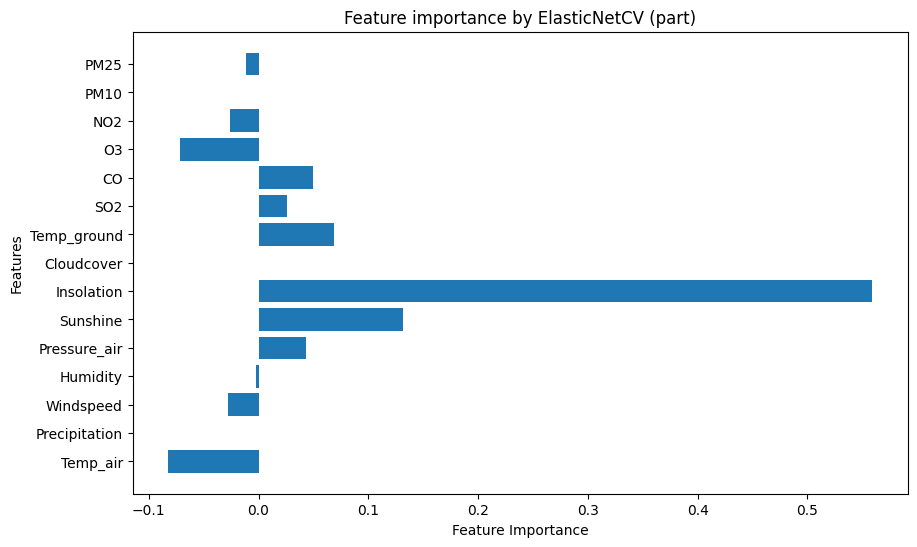

In [72]:
# ElasticNetCV의 결과를 출력합니다.
# 특성 중요도를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(range(len(enet_train.coef_)), enet_train.coef_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(len(enet_train.coef_)), enet_train.feature_names_in_)
plt.title('Feature importance by ElasticNetCV (part)')
plt.show()

# AutoML 학습을 위한 데이터셋 설정

In [76]:
# H2O 라이브러리 초기화
h2o.init()

# H2O 데이터프레임으로 변환
h2o_train = h2o.H2OFrame(train.drop('Date', axis=1))

# Date 열을 제외한 특성과 타겟 변수를 정의
x = h2o_train.columns
x.remove('solarpower')

y = 'solarpower'

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,57 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,"7 days, 2 hours and 49 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_szvrfj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.167 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# AutoML 설정 및 모델 훈련 (모든 파라미터를 원하는 값으로 변경하여 설정)
aml = H2OAutoML(
     max_runtime_secs=3600,     # AutoML 실행에 허용할 최대 시간 (초)
    # max_models=20,             # 생성할 최대 모델 수
    stopping_metric='RMSE',    # 조기 종료를 위한 평가 지표
    stopping_tolerance=0.01,  # 조기 종료를 위한 허용 오차
    stopping_rounds=4,         # 조기 종료를 위한 반복 횟수
    nfolds=10,                  # 교차 검증(fold)의 개수
    seed=42,                   # 랜덤 시드
    exclude_algos = ["StackedEnsemble"],

   #include_algos=['Deeplearning'], #'DRF', 'XGBoost'],  # 사용할 알고리즘들의 리스트
    keep_cross_validation_predictions=True,  # 교차 검증 예측 결과 보존 여부
    keep_cross_validation_models=False,      # 교차 검증 모델 보존 여부
    keep_cross_validation_fold_assignment=False,  # 교차 검증 폴드 할당 보존 여부
    sort_metric='RMSE',        # 성능 측정 기준
    export_checkpoints_dir=None  # 모델 체크포인트를 내보낼 디렉토리
)

aml.train(x=x, y=y, training_frame=h2o_train)

AutoML progress: |███████████████

# Automl 학습결과 확인

In [ ]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# 모든 모델의 성능 순위를 변수로 저장
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    exec(f"model_rank_{rank} = h2o.get_model('{model_id}')")

# 모든 모델의 성능 순위 출력
print("\n<< 모든 모델의 성능 순위 >>")
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    print(f"Model: {model_id}, Rank: {rank}")


In [ ]:
# 순위별로 모델에 대한 세부 정보 출력
# n등의 모델을 출력하려면 : print(model_rank_n)
print(model_rank_1)

In [ ]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# Excel 파일 생성
writer = pd.ExcelWriter('train_result.xlsx', engine='xlsxwriter')

# 모든 모델의 파라미터 정보를 저장하는 새로운 열을 추가합니다.
all_parameters = []
for index, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)
    model_params = model.params
    all_parameters.append(model_params)

leaderboard_df['Parameters'] = all_parameters

# DataFrame을 첫 번째 시트로 저장합니다.
leaderboard_df.to_excel(writer, sheet_name='Leaderboard', index=True)



# 엑셀 파일 저장
writer.save()


model_id                                                      rmse          mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20230802_102330     0.0229133  0.000525017  0.0123954  0.0177963               0.000525017
StackedEnsemble_AllModels_4_AutoML_1_20230802_102330     0.0229155  0.00052512   0.0123956  0.0177966               0.00052512
StackedEnsemble_BestOfFamily_4_AutoML_1_20230802_102330  0.02324    0.000540096  0.0128118  0.0180589               0.000540096
StackedEnsemble_AllModels_2_AutoML_1_20230802_102330     0.0236336  0.000558549  0.0131931  0.0183686               0.000558549
StackedEnsemble_AllModels_1_AutoML_1_20230802_102330     0.0236372  0.000558719  0.0131946  0.018371                0.000558719
GBM_grid_1_AutoML_1_20230802_102330_model_10             0.0237829  0.000565624  0.0131797  0.018483                0.000565624
GBM_grid_1_AutoML_1_20230802_102330_model_2              0.024006   0.00057629   0.0129806  0.0186409    

<ipython-input-16-d0d42f4991af>:27: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


# 모델 학습 결과 시각화 용

In [ ]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 평균값 계산
group_means = grouped_leaderboard['rmse'].mean()

# 그룹 평균값을 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(group_means.index, group_means.values)
plt.xlabel('Average RMSE')
plt.title('H2OAutoML Leaderboard - Average RMSE by Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 1위 모델 선택 (가장 낮은 RMSE 값을 가진 모델)
top_1_models = grouped_leaderboard.apply(lambda group: group.nsmallest(1, 'rmse'))

# 메인 모델별 1위 모델의 RMSE를 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(top_1_models['model_id'], top_1_models['rmse'])
plt.xlabel('RMSE')
plt.title('H2OAutoML Leaderboard - Top 1 Model per Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()


# best 모델 출력하고, 예측을 위한 df 변환

In [ ]:
# 가장 성능이 좋은 모델 선택
best_model = aml.leader

# 선택된 특성 출력
print("Best model is: ", best_model)

Best model is:  Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20230802_102330


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       8/78
# GBM base models (used / total)           6/31
# XGBoost base models (used / total)       2/40
# DRF base models (used / total)           0/2
# DeepLearning base models (used / total)  0/4
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.00012424873219434748
RMSE: 0.011146691535803235
MAE: 0.006492473417058

In [ ]:
# MAPE 계산 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 테스트 데이터를 H2O 데이터프레임으로 변환
h2o_test = h2o.H2OFrame(test.drop('Date', axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# 원하는 rank의 모델 사용하여 test data 예측 수행

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 131.83029965649166
평균 절대 오차 (MAE): 5.6709304424685545
결정 계수 (R2): 0.9756582731990248
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 11.481737658407445


<ipython-input-18-b056e2400552>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


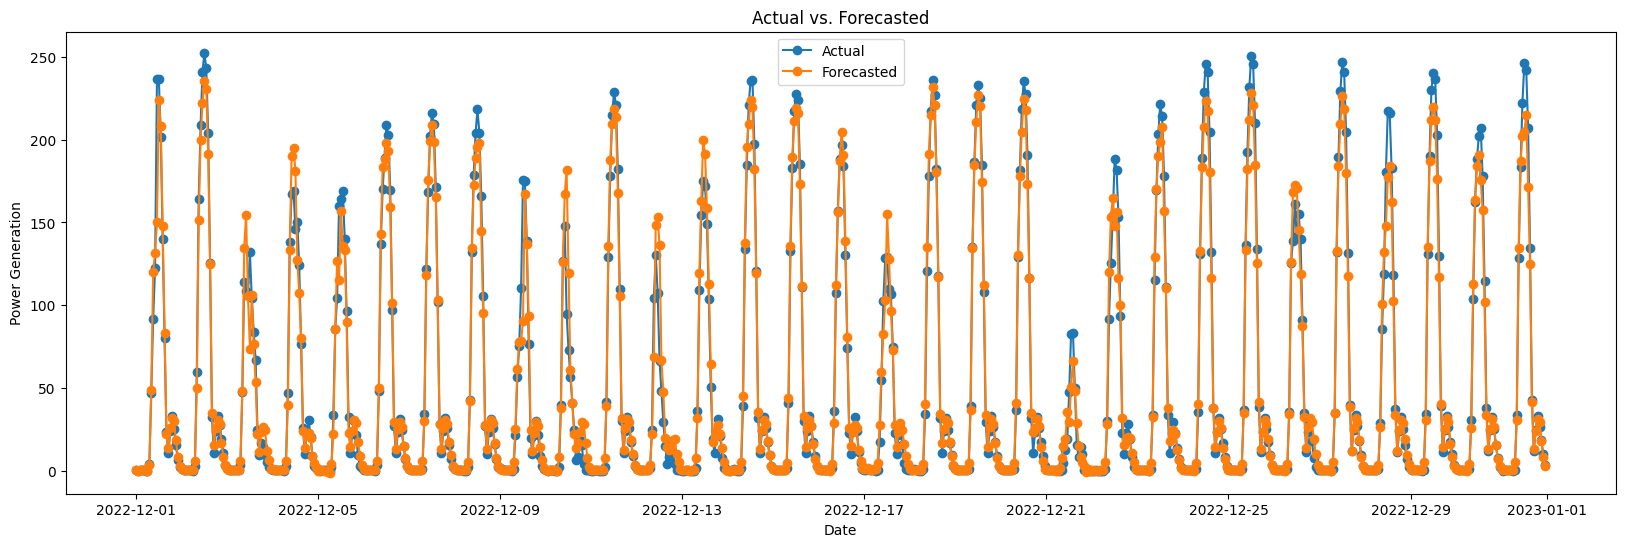

In [ ]:
# 원하는 rank의 모델을 사용하여 예측 수행
predictions = model_rank_1.predict(h2o_test) #model_rank_n
predictions = predictions.as_data_frame()

# 예측된 값을 원래 스케일로 역변환
predictions = target_scaler.inverse_transform(predictions)

# 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
actual_values = test['Solarpower'].values.reshape(-1, 1)
actual_values = target_scaler.inverse_transform(actual_values)

# 평가 지표 계산
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)
mape = mean_absolute_percentage_error(actual_values, predictions)
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

# 실제 값과 예측값 시각화
plt.figure(figsize=(20, 6))
plt.plot(test['Date'], actual_values, label='Actual', marker='o')
plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Forecasted')
plt.legend()
plt.show()


# (안해도됨) best model 예측

In [ ]:
# 가장 좋은 모델인 best_model을 사용하여 예측 수행
predictions = best_model.predict(h2o_test)
predictions = predictions.as_data_frame()

# 예측된 값을 원래 스케일로 역변환
predictions = target_scaler.inverse_transform(predictions)

# 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
actual_values = test['Solarpower'].values.reshape(-1, 1)
actual_values = target_scaler.inverse_transform(actual_values)

# 평가 지표 계산
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)
mape = mean_absolute_percentage_error(actual_values, predictions)
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

# 실제 값과 예측값 시각화
plt.figure(figsize=(10, 6))
plt.plot(test['Date'], actual_values, label='Actual', marker='o')
plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Forecasted')
plt.legend()
plt.show()
